CIFAR10 분류기  
CIFAR-10  
CIFAR-100  
Canadian Institute for Advanced Research  

In [13]:
%matplotlib inline

In [14]:
import tensorflow.keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization

# import cnn_utils as utils
import matplotlib.pyplot as plt

In [15]:
params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15, 5)}
plt.rcParams.update(params)

In [16]:
np.random.seed(55)

## 파라미터

In [17]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 25
INPUT_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
KFOLD_WEIGHT_PATH = 'cnn_cifar10_wights_{epoch:02d}_{val_accuracy:.2f}.hdf5'

In [18]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}
TOP_N = 1

## CIFAR10 데이타 로딩

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [20]:
x_train = x_train / 255.
x_test = x_test / 255.

## 데이타 상세

In [21]:
print('x_train shape :', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape : (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [22]:
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

### 신경망 구축

In [23]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
          kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
         padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

## 네트워크 아키텍처 시각화

In [ ]:
# https://graphviz.gitlab.io/download/
# windows 10 어플리케이션 추가로 설치 히야 됨
# !pip install pydot graphviz

In [37]:
# from tensorflow.keras.utils import plot_model
# plot_model(model,show_shapes=True)

In [26]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
             optimizer=tensorflow.keras.optimizers.Adadelta(),
             metrics=['accuracy'])

In [27]:
early_stop_callback = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                      ModelCheckpoint(KFOLD_WEIGHT_PATH, monitor='val_loss',
                                     save_best_only=True, verbose=0)]

In [28]:
history = model.fit(x_train, y_train,
                   validation_split=0.1,
                   batch_size=BATCH_SIZE,
                   epochs=10,
                   verbose=1,
                   callbacks=early_stop_callback)

Epoch 1/10
352/352 [==============================] - 27s 74ms/step - loss: 3.1924 - accuracy: 0.1195 - val_loss: 2.2543 - val_accuracy: 0.1686
Epoch 2/10
352/352 [==============================] - 27s 78ms/step - loss: 2.7755 - accuracy: 0.1434 - val_loss: 2.1740 - val_accuracy: 0.2114
Epoch 3/10
352/352 [==============================] - 29s 81ms/step - loss: 2.5756 - accuracy: 0.1634 - val_loss: 2.1015 - val_accuracy: 0.2390
Epoch 4/10
352/352 [==============================] - 29s 83ms/step - loss: 2.4486 - accuracy: 0.1810 - val_loss: 2.0480 - val_accuracy: 0.2618
Epoch 5/10
352/352 [==============================] - 30s 84ms/step - loss: 2.3628 - accuracy: 0.1951 - val_loss: 2.0091 - val_accuracy: 0.2820
Epoch 6/10
352/352 [==============================] - 30s 86ms/step - loss: 2.2953 - accuracy: 0.2074 - val_loss: 1.9788 - val_accuracy: 0.2962
Epoch 7/10
352/352 [==============================] - 31s 88ms/step - loss: 2.2477 - accuracy: 0.2171 - val_loss: 1.9543 - val_accuracy:

In [29]:
model.save(filepath='cnn_cifar10.h5')

## 모델 성틍 테스트 및 예측

In [30]:
score = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 4s 14ms/step - loss: 1.8943 - accuracy: 0.3374


In [31]:
print('Test loss : ' , score[0])
print('Test accuracy : ', score[1])

Test loss :  1.8942877054214478
Test accuracy :  0.33739998936653137


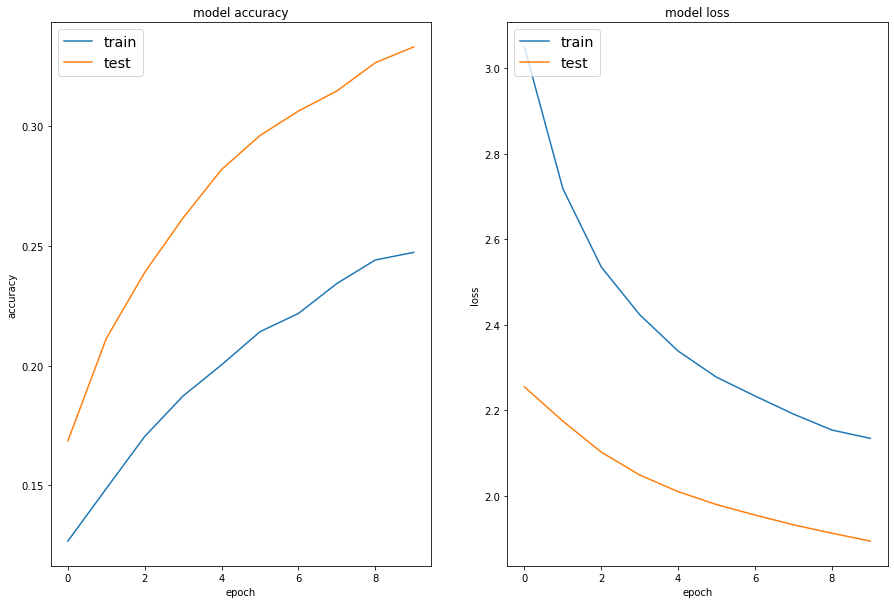

In [32]:
plt.figure(1, figsize=(15, 10))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CNN 이미지 분류 확인 방법

In [33]:
def make_prediction(model=None,img_vector=[],
                    label_dict={},top_N=3, 
                    model_input_shape=None):
    if model:
        # get model input shape
        if not model_input_shape:
            model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
            
        # get prediction
        prediction = model.predict(img_vector.reshape(model_input_shape))[0]
        
        
        # get top N with confidence
        labels_predicted = [label_dict[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
        confidence_predicted = np.sort(prediction)[::-1][:top_N]
        
        return labels_predicted, confidence_predicted

In [34]:
def plot_predictions(model,dataset,dataset_labels,label_dict,
                    batch_size,grid_height,grid_width):
    if model:
        f, ax = plt.subplots(grid_width, grid_height)
        f.set_size_inches(12, 12)
        random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]
        img_idx = 0
        for i in range(0, grid_width):
            for j in range(0, grid_height):
                actual_label = label_dict.get(dataset_labels[random_batch_indx[img_idx]].argmax())
                preds,confs_ = make_prediction(model,
                                              img_vector=dataset[random_batch_indx[img_idx]],
                                              label_dict=label_dict,
                                              top_N=1,
                                              model_input_shape=(1,32,32,3))
                ax[i][j].axis('off')
                ax[i][j].set_title('Actual:'+actual_label[:10]+\
                                    '\nPredicted:'+preds[0] + \
                                    '(' +str(round(confs_[0],2)) + ')')
                ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
                img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, 
                            top=1, wspace=0.4, hspace=0.55)  

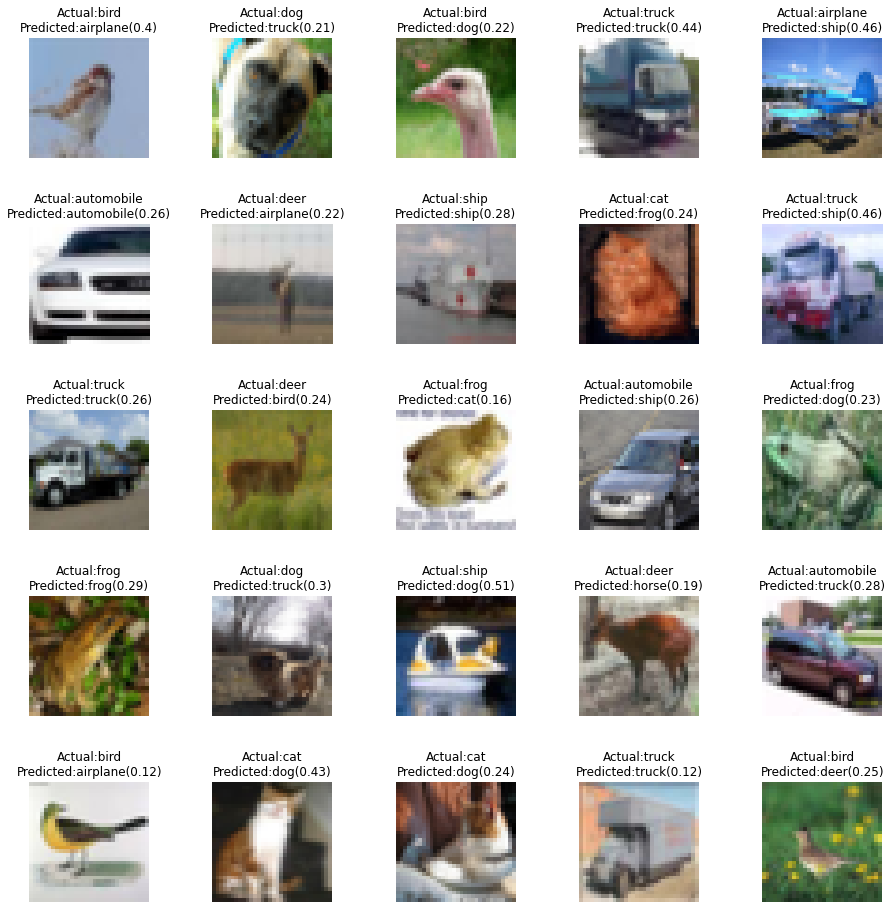

In [35]:
plot_predictions(model=model,dataset=x_test,
                       dataset_labels=y_test,
                       label_dict=label_dict,
                       batch_size=BATCH_SIZE,
                       grid_height=5,
                       grid_width=5)